In [1]:
import os
import cv2
from glob import glob
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor, TrainingArguments, Trainer
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, recall_score, jaccard_score, precision_score
import matplotlib.pyplot as plt
import evaluate

ERROR:albumentations.check_version:Error fetching version info
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/urllib/request.py", line 1348, in do_open
    h.request(req.get_method(), req.selector, req.data, headers,
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/http/client.py", line 1303, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/http/client.py", line 1349, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/http/client.py", line 1298, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/http/client.py", line 1058, in _send_output
    self.send(msg)
  File "/Library/Frameworks/Python.framework/

## Data Processing

In [2]:
class Process_Datasets(Dataset):
    def __init__(self, root_dir, image_processor):
        self.root_dir = root_dir
        self.image_processor = image_processor

        self.image_path = os.path.join(self.root_dir, "img")
        self.mask_path = os.path.join(self.root_dir, "mask")

        image_files = [f for f in os.listdir(self.image_path) if '.png' in f]
        mask_files = [f for f in os.listdir(self.mask_path) if '.png' in f]
        self.images = sorted(image_files)
        self.masks = sorted(mask_files)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_path = os.path.join(self.image_path, self.images[index])
        mask_path = os.path.join(self.mask_path, self.masks[index])

        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        encoded = self.image_processor(image, mask, return_tensors="pt")

        for k,v in encoded.items():
            encoded[k].squeeze_()

        return encoded

In [3]:
pre_trained_model = 'nvidia/segformer-b0-finetuned-ade-512-512'
image_processor = SegformerImageProcessor.from_pretrained(pre_trained_model)

def load_datasets(root_dir):
    batch_size=4
    image_processor.do_reduce_labels = False
    image_processor.size = 256

    dataset = Process_Datasets(root_dir=root_dir, image_processor=image_processor)
    train, val = train_test_split(dataset, test_size=0.2)
    val, test = train_test_split(val, test_size=0.01)

    train_dataset = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dataset = DataLoader(val, batch_size=batch_size, shuffle=True)
    test_dataset = DataLoader(test, shuffle=True)

    return train_dataset, val_dataset, test_dataset

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/models/segformer/image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [4]:
covid_train, covid_val, covid_test = load_datasets(root_dir="./Datasets/COVID-19/COVID")
len(covid_train), len(covid_val), len(covid_test)

(723, 179, 8)

## Model Implementation

In [5]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def val_metrics(metric):
    avg_iou = metric['IoU'].mean()
    avg_accur = metric['Accuracy'].mean()
    avg_prec = metric['Precision'].mean()
    avg_recall = metric['Recall'].mean()
    avg_f1 = metric['F1'].mean()

    print(f"IoU: {avg_iou}, Accuracy: {avg_accur}, Precision: {avg_prec}, Recall: {avg_recall}, F1 Score: {avg_f1}")

def train_model(train_data, val_data):
    epochs = 20

    model = SegformerForSemanticSegmentation.from_pretrained(pre_trained_model, ignore_mismatched_sizes=True)
    optimizer = optim.Adam(model.parameters(), lr=0.0025)
    val_metrics = []

    # Train network
    for ep in range(epochs):
        train_loss = []
        val_loss = []

        model.train()
        for index, batch in enumerate(tqdm(train_data)):
            image = batch["pixel_values"]
            mask = batch["labels"]
            optimizer.zero_grad()
            
            outputs = model(pixel_values=image, labels=mask)
            loss = outputs.loss

            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            for index, batch in enumerate(tqdm(val_data)):
                image = batch["pixel_values"]
                mask = batch["labels"]
                optimizer.zero_grad()

                outputs = model(pixel_values=image, labels=mask)
                logits = F.interpolate(outputs.logits, size=mask.shape[-2:], mode="bilinear", align_corners=False)
                prediction = logits.argmax(dim=1)

                for pred, true in zip(prediction, mask):
                    pred_mask = pred.cpu().numpy()
                    true_mask = true.cpu().numpy()

                    iou = jaccard_score(true_mask.flatten(), pred_mask.flatten(), average='weighted')
                    accuracy = accuracy_score(true_mask.flatten(), pred_mask.flatten())
                    precision = precision_score(true_mask.flatten(), pred_mask.flatten(), average='weighted')
                    recall = recall_score(true_mask.flatten(), pred_mask.flatten(), average='weighted')
                    f1 = f1_score(true_mask.flatten(), pred_mask.flatten(), average='weighted')
                    val_metrics.append([iou, accuracy, precision, recall, f1])

                loss = outputs.loss
                val_loss.append(loss.item())
                optimizer.step()

        print(f"Epoch [{ep+1}/{epochs}]. Training Loss [{np.mean(train_loss)}]. Validation Loss [{np.mean(val_loss)}]")

    metrics = pd.DataFrame(val_metrics, columns=["IoU", "Accuracy", "Precision", "Recall", "F1"])
    return model, metrics

In [6]:
covid_model, covid_metrics = train_model(covid_train, covid_val)

100%|██████████| 179/179 [02:09<00:00,  1.38it/s]


Epoch [1/20]. Training Loss [0.006277571187681157]. Validation Loss [5.7982446469903753e-05]


100%|██████████| 179/179 [01:59<00:00,  1.50it/s]


Epoch [2/20]. Training Loss [3.6145691053696316e-05]. Validation Loss [4.358852032832827e-05]


100%|██████████| 179/179 [01:59<00:00,  1.50it/s]


Epoch [3/20]. Training Loss [1.6043381073897744e-05]. Validation Loss [8.204050707758772e-06]


100%|██████████| 179/179 [02:00<00:00,  1.48it/s]


Epoch [4/20]. Training Loss [7.737462382236363e-06]. Validation Loss [5.234141463768527e-06]


100%|██████████| 179/179 [01:37<00:00,  1.85it/s]


Epoch [5/20]. Training Loss [4.606825287892634e-06]. Validation Loss [2.1601259884480683e-06]


100%|██████████| 179/179 [01:37<00:00,  1.84it/s]


Epoch [6/20]. Training Loss [2.7463241705078544e-06]. Validation Loss [8.229136807263104e-07]


100%|██████████| 179/179 [01:36<00:00,  1.85it/s]


Epoch [7/20]. Training Loss [1.8817780912506707e-06]. Validation Loss [2.0211151821556527e-06]


100%|██████████| 179/179 [01:39<00:00,  1.81it/s]


Epoch [8/20]. Training Loss [1.022494501551794e-06]. Validation Loss [3.04049758381161e-07]


100%|██████████| 179/179 [01:38<00:00,  1.82it/s]


Epoch [9/20]. Training Loss [5.602597177645019e-07]. Validation Loss [3.612911172171681e-07]


100%|██████████| 179/179 [01:39<00:00,  1.79it/s]


Epoch [10/20]. Training Loss [3.6573164998235856e-07]. Validation Loss [2.51651140477193e-07]


100%|██████████| 179/179 [01:39<00:00,  1.80it/s]


Epoch [11/20]. Training Loss [3.2075337462887524e-07]. Validation Loss [1.2885562793310748e-07]


100%|██████████| 179/179 [01:38<00:00,  1.81it/s]


Epoch [12/20]. Training Loss [1.8295730295638516e-07]. Validation Loss [7.51051393194122e-08]


100%|██████████| 179/179 [01:38<00:00,  1.81it/s]


Epoch [13/20]. Training Loss [1.3368622157907797e-07]. Validation Loss [1.7579196886493795e-08]


100%|██████████| 179/179 [01:39<00:00,  1.80it/s]


Epoch [14/20]. Training Loss [7.002458935061997e-08]. Validation Loss [2.408210200447508e-10]


100%|██████████| 179/179 [01:38<00:00,  1.82it/s]


Epoch [15/20]. Training Loss [4.593376372570831e-08]. Validation Loss [5.480023667622465e-09]


100%|██████████| 179/179 [01:38<00:00,  1.82it/s]


Epoch [16/20]. Training Loss [2.4918129960263488e-08]. Validation Loss [1.8651424386949424e-09]


100%|██████████| 179/179 [01:38<00:00,  1.82it/s]


Epoch [17/20]. Training Loss [1.4930561061665298e-08]. Validation Loss [3.2933137136054882e-09]


100%|██████████| 179/179 [01:39<00:00,  1.79it/s]


Epoch [18/20]. Training Loss [2.7007579142129075e-08]. Validation Loss [8.060421494754048e-09]


100%|██████████| 179/179 [01:38<00:00,  1.81it/s]


Epoch [19/20]. Training Loss [7.1584242116806926e-09]. Validation Loss [4.5768959116546924e-10]


100%|██████████| 179/179 [01:38<00:00,  1.81it/s]

Epoch [20/20]. Training Loss [3.7744112336500845e-09]. Validation Loss [2.785463884686588e-10]


In [8]:
covid_metrics.to_csv("./results/covid_segformer.csv", index=False)
val_metrics(covid_metrics)

IoU: 0.5762199576278789, Accuracy: 0.7557585945342506, Precision: 0.5762199576278789, Recall: 0.7557585945342506, F1 Score: 0.6525566058651011


## Model Evaluation

In [9]:
def image_display(model, test_data):
    for index, batch in enumerate(tqdm(test_data)):
        image = batch["pixel_values"]
        mask = batch["labels"]

        outputs = model(image)
        prediction = torch.argmax(outputs.logits, 1)
        
        image = image.squeeze()
        fig, ax = plt.subplots(1, 3, figsize=(12, 8))
        ax[0].imshow(image.permute(1, 2, 0))
        ax[1].imshow(mask.permute(1, 2, 0))
        ax[2].imshow(prediction.permute(1, 2, 0))

        ax[0].set_title(f'Test Image')
        ax[1].set_title(f'True Mask')
        ax[2].set_title(f'Predicted Mask')

100%|██████████| 8/8 [00:00<00:00,  8.33it/s]


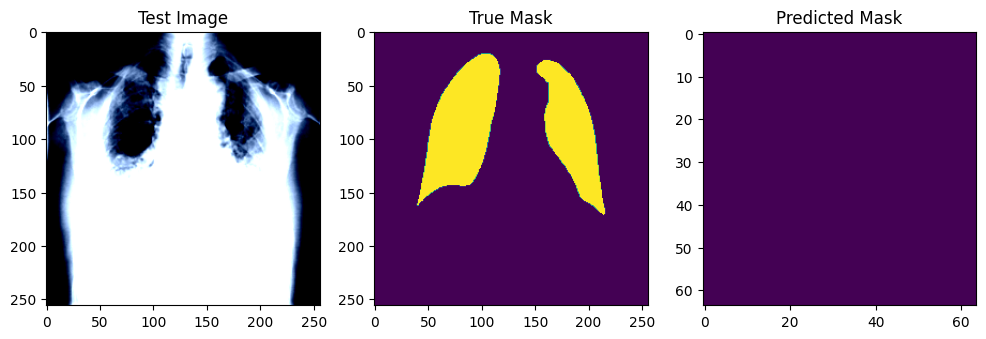

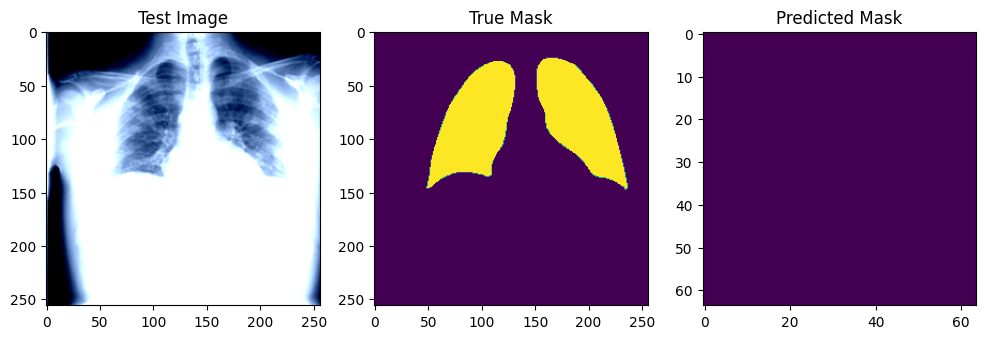

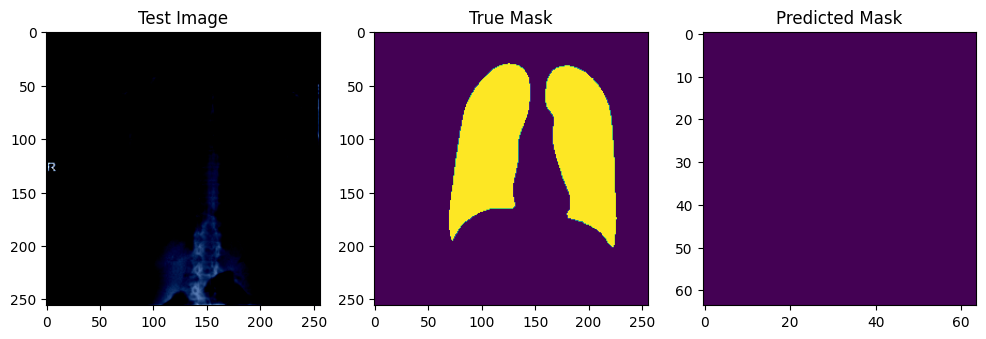

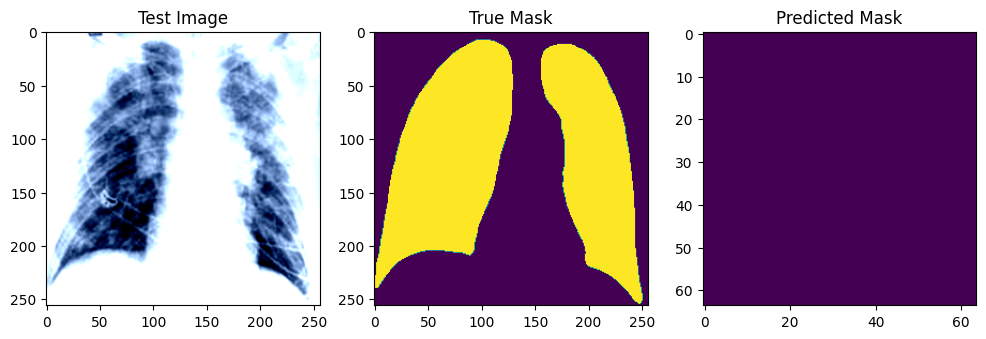

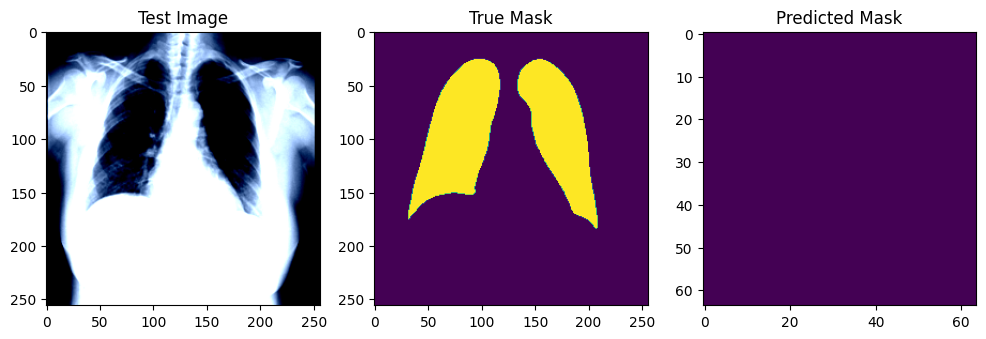

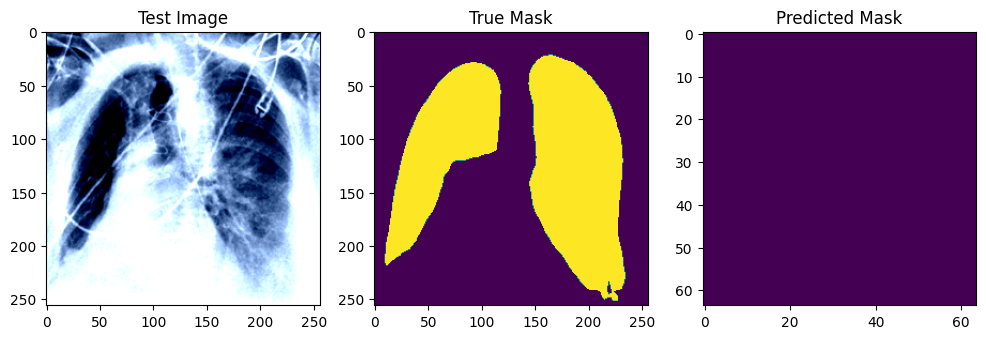

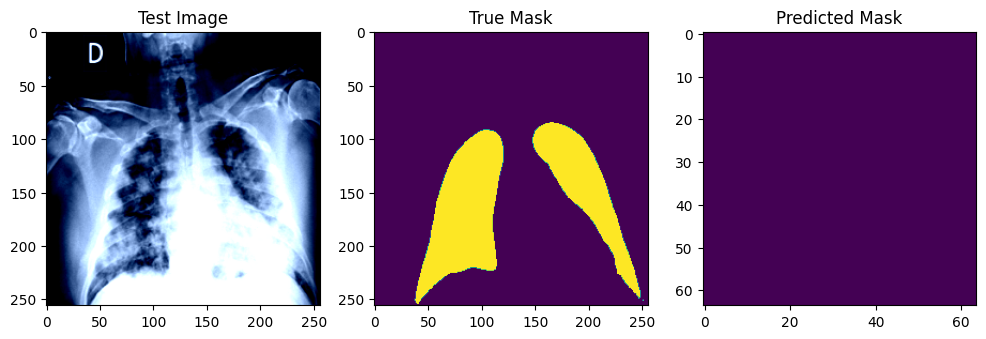

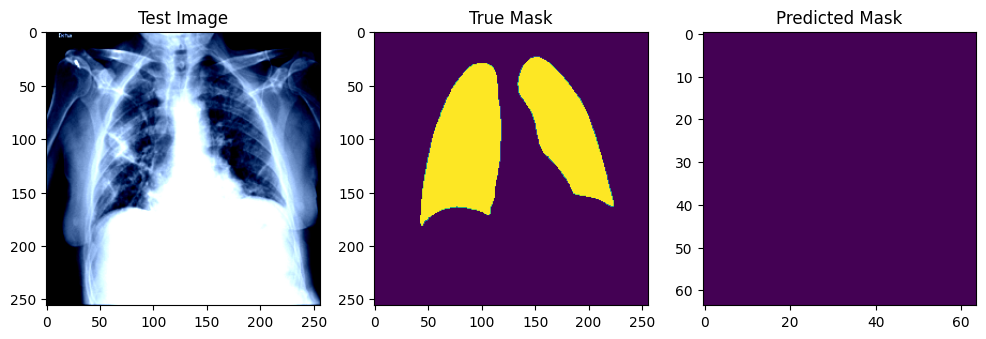

In [10]:
image_display(covid_model, covid_test)